In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [5]:
%%time 
adata = sc.read_h5ad("../../perturb_cite_seq_data/SCP1064/other/adata.h5ad")
adata.X.data

CPU times: user 1.47 s, sys: 8.29 s, total: 9.77 s
Wall time: 10.7 s


array([2., 1., 1., ..., 2., 1., 1.])

In [6]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

In [18]:
for val in adata.obs[["sgRNA", "sgRNAs"]].value_counts().to_frame().iterrows():
    print(val[0], val[1])

('IFNGR2_2', 'IFNGR2_2') 0    358
Name: (IFNGR2_2, IFNGR2_2), dtype: int64
('NO_SITE_47', 'NO_SITE_47') 0    333
Name: (NO_SITE_47, NO_SITE_47), dtype: int64
('NO_SITE_913', 'NO_SITE_913') 0    317
Name: (NO_SITE_913, NO_SITE_913), dtype: int64
('HLA-DRB5_2', 'HLA-DRB5_2') 0    315
Name: (HLA-DRB5_2, HLA-DRB5_2), dtype: int64
('NO_SITE_23', 'NO_SITE_23') 0    296
Name: (NO_SITE_23, NO_SITE_23), dtype: int64
('NO_SITE_36', 'NO_SITE_36') 0    296
Name: (NO_SITE_36, NO_SITE_36), dtype: int64
('ONE_NON-GENE_SITE_531', 'ONE_NON-GENE_SITE_531') 0    296
Name: (ONE_NON-GENE_SITE_531, ONE_NON-GENE_SITE_531), dtype: int64
('CD59_2', 'CD59_2') 0    287
Name: (CD59_2, CD59_2), dtype: int64
('FGFR1_1', 'FGFR1_1') 0    285
Name: (FGFR1_1, FGFR1_1), dtype: int64
('JAK2_1', 'JAK2_1') 0    285
Name: (JAK2_1, JAK2_1), dtype: int64
('JMJD7_1', 'JMJD7_1') 0    283
Name: (JMJD7_1, JMJD7_1), dtype: int64
('JAK1_2', 'JAK1_2') 0    283
Name: (JAK1_2, JAK1_2), dtype: int64
('NO_SITE_678', 'NO_SITE_678') 0    

('PABPC1_3', 'PABPC1_3') 0    81
Name: (PABPC1_3, PABPC1_3), dtype: int64
('PFDN4_2', 'PFDN4_2') 0    80
Name: (PFDN4_2, PFDN4_2), dtype: int64
('BOLA2B_2', 'BOLA2B_2') 0    80
Name: (BOLA2B_2, BOLA2B_2), dtype: int64
('RNASEH2A_2', 'RNASEH2A_2') 0    80
Name: (RNASEH2A_2, RNASEH2A_2), dtype: int64
('PFN1_3', 'PFN1_3') 0    79
Name: (PFN1_3, PFN1_3), dtype: int64
('UQCRH_3', 'UQCRH_3') 0    79
Name: (UQCRH_3, UQCRH_3), dtype: int64
('PABPC1_1', 'PABPC1_1') 0    79
Name: (PABPC1_1, PABPC1_1), dtype: int64
('CCND1_1', 'CCND1_1') 0    78
Name: (CCND1_1, CCND1_1), dtype: int64
('MRPL47_3', 'MRPL47_3') 0    78
Name: (MRPL47_3, MRPL47_3), dtype: int64
('UQCRH_2', 'UQCRH_2') 0    76
Name: (UQCRH_2, UQCRH_2), dtype: int64
('ST6GALNAC2_3', 'ST6GALNAC2_3') 0    76
Name: (ST6GALNAC2_3, ST6GALNAC2_3), dtype: int64
('PET100_2', 'PET100_2') 0    74
Name: (PET100_2, PET100_2), dtype: int64
('PET100_3', 'PET100_3') 0    74
Name: (PET100_3, PET100_3), dtype: int64
('TMED10_3', 'TMED10_3') 0    74
Name:

In [ ]:
(adata.obs["n_genes"] < 500).sum(), (adata.var["n_cells"] < 500).sum()

In [ ]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=500)

In [ ]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e5)
sc.pp.log1p(adata)

In [ ]:
# make sure we can match sgRNAs back to the genes
adata.obs

In [8]:
# check if the field MOI has some irregularities, such that a truncated guide or a wrong number
ind = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    flag = False
    if row["sgRNAs"] != "":
        guides = row["sgRNAs"].split(",")
        if len(guides) != row["MOI"]:
            flag = True
        if "_" not in guides[-1]:
            flag = True
    if flag:
        ind += [index]

100%|██████████| 218027/218027 [00:10<00:00, 21769.66it/s]


In [9]:
# empty!!
ind

[]

In [10]:
# check gene sets and ensure matching with measurements
err = 0
ind = []
obs_genes = {}
unfound_genes = {}
targets = []
for index, row in tqdm(adata.obs.iterrows(), total=adata.n_obs):
    current_target = []
    if row["sgRNAs"] != "":
        # get all guides in cells
        sg = row["sgRNAs"].split(",")
        # get gene name by stripping guide specific info
        sg_genes = [guide.rsplit("_", maxsplit=1)[0] for guide in sg]
        for gene in sg_genes:
            if gene in adata.var.index:
                # gene is found
                current_target += [gene]
                if gene not in obs_genes:
                    obs_genes[gene] = 1
                else:
                    obs_genes[gene] += 1
            else:
                if gene not in unfound_genes:
                    unfound_genes[gene] = 1
                else:
                    unfound_genes[gene] += 1
    # end gene list
    targets += [",".join(current_target)]

100%|██████████| 218027/218027 [00:10<00:00, 20390.70it/s]


In [11]:
# create regimes
regimes = np.unique(targets, return_inverse=True)[1]

In [52]:
len(regimes)

218027

In [12]:
adata.obs["targets"] = targets
adata.obs["regimes"] = regimes

In [13]:
len(obs_genes.keys())

220

In [14]:
# some leftover genes I couldn't match
unfound_genes.keys()

dict_keys(['NGFR', 'SERPINF1', 'CSPG4', 'PIK3IP1', 'ONE_NON-GENE_SITE', 'NO_SITE', 'NUP50-AS1', 'IDI2-AS1', 'CXCR4', 'JMJD7', 'TYR', 'BOLA2', 'LRRC75A-AS1', 'LINC00518', 'APOD', 'A2M', 'LEF1-AS1', 'SLC7A5P1', 'SERPINA3', 'WNT7A', 'GAS5', 'IRF4', 'APOC2', 'XAGE1A', 'CCND2', 'CDH19', 'ST6GALNAC2', 'S100B', 'HLA-H', 'SNHG6'])

## Step 2: Comparing variability of gene expression to guide ID

In [15]:
%%time
sc.pp.highly_variable_genes(adata, layer="counts", flavor='seurat_v3', n_top_genes=3000 , span=0.2)

CPU times: user 34.3 s, sys: 22.6 s, total: 56.9 s
Wall time: 1min 9s


In [16]:
adata.var

,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
A1BG,34703,True,1689.0,0.189256,0.232778,1.069112
A1BG-AS1,12461,False,NaN,0.060226,0.063213,0.964280
A4GALT,1537,False,NaN,0.007233,0.007566,0.985149
AAAS,39657,False,NaN,0.213538,0.241693,0.970792
AACS,19249,False,NaN,0.094887,0.099974,0.948419
...,...,...,...,...,...,...
ZXDB,2581,False,NaN,0.011994,0.012162,0.957151
ZXDC,14586,False,NaN,0.070569,0.073387,0.947735
ZYG11B,26023,False,NaN,0.132493,0.144036,0.972143
ZYX,153542,False,NaN,1.634701,3.017341,0.954339


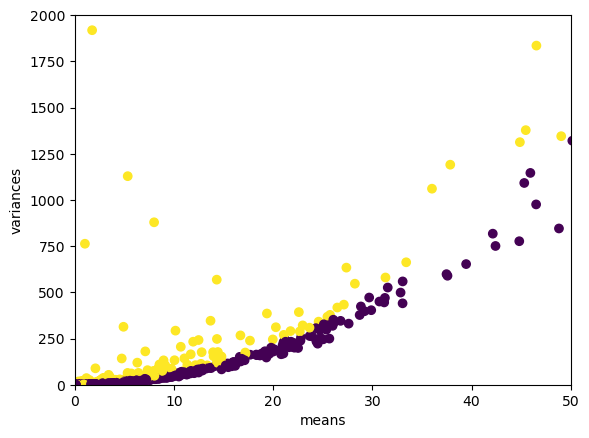

In [17]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["highly_variable"])
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [18]:
presence = pd.Series(data=np.zeros_like(adata.var["means"]), index=adata.var.index)
for gene in list(obs_genes.keys()):
    presence[gene] += 1
adata.var["targeted"] = presence

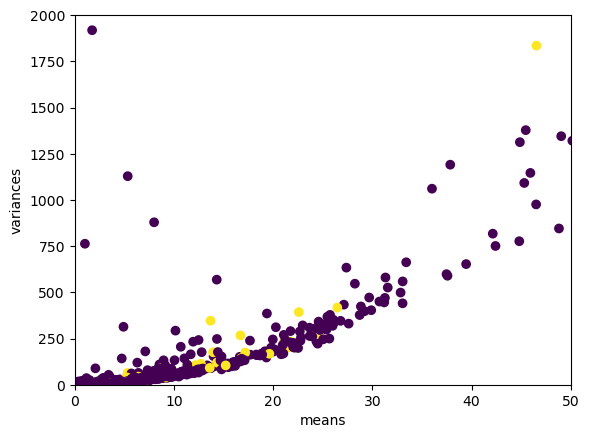

In [19]:
plt.scatter(adata.var["means"], adata.var["variances"], c=adata.var["targeted"])
plt.xlabel("means")
plt.ylabel("variances")
plt.xlim((0, 50))
plt.ylim((0, 2000))
plt.show()

In [20]:
# out of 3000 highly variable genes, and 250 targeted genes, only 96 is in the intersection
(adata.var["highly_variable"] * adata.var["targeted"]).sum()
# for future reference we probably add all intervened genes and complete with highly variable 

100.0

In [21]:
np.unique(adata.obs.condition.values)

array(['Co-culture', 'Control', 'IFNγ'], dtype=object)

In [23]:
# filter genes (1000)
to_keep = np.logical_or(adata.var["highly_variable_rank"] < 1500, adata.var["targeted"])
adata_gf = adata[:, to_keep].copy()

In [25]:
# Loading the preselected genes
chosen_genes = pd.read_csv("../../perturb_cite_seq_data/220930_PerturbCITE_regulators.csv")
chosen_genes = chosen_genes.to_numpy().T.squeeze()

In [28]:
present = 0
final_genes = list()
for gene in chosen_genes:
    if gene.upper() in adata_gf.var[adata.var["targeted"] > 0].index:
        present += 1
        final_genes.append(gene.upper())
    
print(present)

Ccl10
Cdh19
Cxcr4
HLA-H
IDI2-AS1
Ngfr
Nup50-as
Wnt7a

61


/scratch/4992671.sched-torque.pace.gatech.edu/ipykernel_8615/1426011582.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if gene.upper() in adata_gf.var[adata.var["targeted"] > 0].index:


In [41]:
in_final_gene = list()
for index, row in adata.var.iterrows():
    if index in final_genes:
        in_final_gene.append(True)
    else:
        in_final_gene.append(False)


adata.var["in_final"] = in_final_gene

In [45]:
to_keep = adata.var["in_final"]
adata_gf = adata[:, to_keep].copy()

In [50]:
adata_gf[adata_gf.obs.condition == "Control"].copy().write_h5ad("../../perturb_cite_seq_data/SCP1064/ready/control/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "Co-culture"].copy().write_h5ad("../../perturb_cite_seq_data/SCP1064/ready/cocult/gene_filtered_adata.h5ad")
adata_gf[adata_gf.obs.condition == "IFNγ"].copy().write_h5ad("../../perturb_cite_seq_data/SCP1064/ready/ifn/gene_filtered_adata.h5ad")

In [51]:
adata_small = adata_gf[np.random.choice(np.arange(adata.n_obs), size=10000, replace=False)].copy()
adata_small.write_h5ad("../../perturb_cite_seq_data/SCP1064/other/small_adata.h5ad")